**Dataset**: Default of Credit Card Clients Repository  
  
**Source**: [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/350/default+of+credit+card+clients)  
  
**Description**: 30,000 clients, 24 features including demographic info, credit limits, payment history, and target `default.payment.next.month`.  
  
**Notes:** The raw file is `.xls`. We will save a cleaned/sample version as `.csv` for easier use in later analysis.


In [29]:
import pandas as pd
import os

# File paths
raw_path = "../../data/raw/default of credit card clients.xls"
processed_path = "../../data/processed/sample_credit_data.csv"

# Create processed directory if it doesn't exist
os.makedirs(os.path.dirname(processed_path), exist_ok=True)

# Load Excel file (skip first title row)
df = pd.read_excel(raw_path, header=1)

# Basic dataset info
print("Shape:", df.shape)
print("\nData types:")
print(df.dtypes.head())
print("\nMissing values per column:")
print(df.isnull().sum().head())

df.head()


Shape: (30000, 25)

Data types:
ID           int64
LIMIT_BAL    int64
SEX          int64
EDUCATION    int64
MARRIAGE     int64
dtype: object

Missing values per column:
ID           0
LIMIT_BAL    0
SEX          0
EDUCATION    0
MARRIAGE     0
dtype: int64


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [30]:
# Create figures directory if it doesn't exist
figures_dir = "../../figures/"
os.makedirs(figures_dir, exist_ok=True)


## B2. Initial Exploratory Data Analysis

We will create **4 visualizations**:
1. Distribution of a key feature (Credit Limit)
2. Class balance (Default vs Non-Default)
3. Relationship between two variables (Age vs Credit Limit)
4. Missing values / data quality

Additionally, we will check for class imbalance and print proportions.


In [31]:
# Create figures directory if it doesn't exist
figures_dir = "../../figures/"
os.makedirs(figures_dir, exist_ok=True)


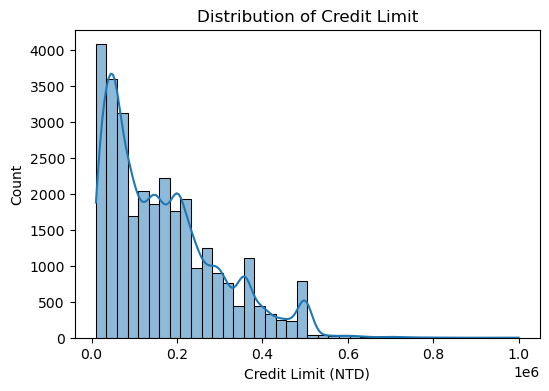

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.histplot(df["LIMIT_BAL"], bins=40, kde=True)
plt.title("Distribution of Credit Limit")
plt.xlabel("Credit Limit (NTD)")
plt.ylabel("Count")
plt.savefig(os.path.join(figures_dir, "distribution_credit_limit.png"))


Class counts:
 default payment next month
0    23364
1     6636
Name: count, dtype: int64
Proportion of default: 0.2212


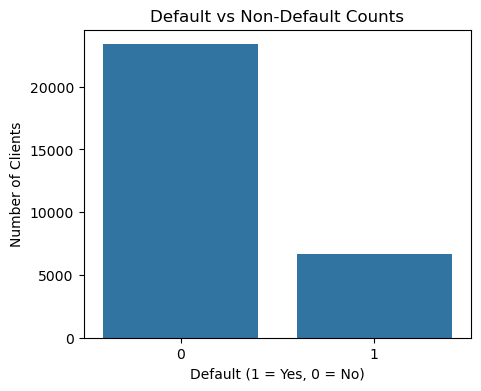

In [33]:
# Count default vs non-default
class_counts = df["default payment next month"].value_counts()
print("Class counts:\n", class_counts)
print("Proportion of default:", class_counts[1] / class_counts.sum())

# Plot class balance
plt.figure(figsize=(5, 4))
sns.countplot(x="default payment next month", data=df)
plt.title("Default vs Non-Default Counts")
plt.xlabel("Default (1 = Yes, 0 = No)")
plt.ylabel("Number of Clients")
plt.savefig(os.path.join(figures_dir, "class_balance.png"))


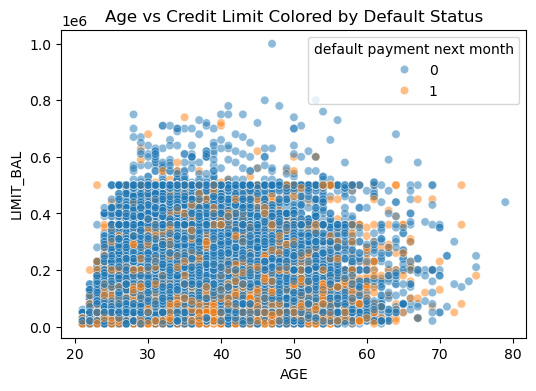

In [34]:
plt.figure(figsize=(6, 4))
sns.scatterplot(
    x="AGE", y="LIMIT_BAL", hue="default payment next month", data=df, alpha=0.5
)
plt.title("Age vs Credit Limit Colored by Default Status")
plt.savefig(os.path.join(figures_dir, "age_vs_credit_limit.png"))


In [35]:
# Check missing values
missing_counts = df.isnull().sum()
missing_cols = missing_counts[missing_counts > 0].index

if len(missing_cols) == 0:
    print("No missing values detected.")
else:
    # Plot heatmap for columns that have missing values
    plt.figure(figsize=(8, 5))
    sns.heatmap(df[missing_cols].isnull(), cbar=False)
    plt.title("Missing Value Heatmap (Columns with Missing Values)")
    plt.savefig(os.path.join(figures_dir, "missing_values_heatmap.png"))


No missing values detected.


## B3. Baseline Model and SMOTE-Ready Preprocessing

Implement:
- Majority class classifier baseline
- Optional Logistic Regression baseline
- SMOTE preprocessing for later neural network modeling


In [36]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

# Features and target
X = df.drop(columns=["default payment next month"])
y = df["default payment next month"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Majority class classifier
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)
y_pred = dummy.predict(X_test)

print("Majority Class Baseline Accuracy:", accuracy_score(y_test, y_pred))
print("Majority Class Baseline F1:", f1_score(y_test, y_pred))


Majority Class Baseline Accuracy: 0.7788333333333334
Majority Class Baseline F1: 0.0


In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

# Select numeric features
num_cols = X.select_dtypes(include="number").columns
X_num = X[num_cols]

# Scale numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_num)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# Logistic Regression
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.82      0.97      0.89      4673
           1       0.69      0.24      0.36      1327

    accuracy                           0.81      6000
   macro avg       0.76      0.61      0.62      6000
weighted avg       0.79      0.81      0.77      6000



In [38]:
from imblearn.over_sampling import SMOTE
import numpy as np

# Apply SMOTE to training data
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Original class distribution:", y_train.value_counts().to_dict())
print("Resampled class distribution:", pd.Series(y_train_res).value_counts().to_dict())

# Save SMOTE-ready datasets for later neural network modeling
processed_dir = "../../data/processed/"
os.makedirs(processed_dir, exist_ok=True)

np.save(os.path.join(processed_dir, "X_train_res.npy"), X_train_res)
np.save(os.path.join(processed_dir, "y_train_res.npy"), y_train_res)
np.save(os.path.join(processed_dir, "X_test.npy"), X_test)
np.save(os.path.join(processed_dir, "y_test.npy"), y_test)

print("Saved SMOTE-ready training and test datasets.")


Original class distribution: {0: 18691, 1: 5309}
Resampled class distribution: {0: 18691, 1: 18691}
Saved SMOTE-ready training and test datasets.
